In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Classification via k-Nearest Neighbors

Générons d’abord des données synthétiques, ou artifcielles, avant de travailler avec des vrais problemes.   Notre modèle génératif sera un modèle de mélange gaussien (GMM, Gaussian Mixture Model): pour chaque classe, nous allons d'abord échantillonner 10 centroïdes différents
${\vec m}_k$ from $\mathcal{N} ({\vec 0}, I_2)$, puis choisissez des centroïdes au hasard et échantillonnez les données réelles de
$\mathcal{N} ({\vec m}_k, \frac{1}{5} I_2)$.

Nous commençons par échantillonner les centroïdes et les tracer.

Text(0.5, 1.0, 'Centroids')

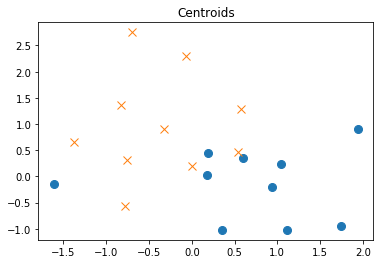

In [4]:
# Samples 10 centroids for each class from two different bivariate Normal distributions
centroids_per_class = 10

class0_centroids = [1, 0] + np.random.randn(centroids_per_class, 2)
class1_centroids = [0, 1] + np.random.randn(centroids_per_class, 2)

# Plot centroids
plt.plot(class0_centroids[:, 0], class0_centroids[:, 1], "o", markersize=8)
plt.plot(class1_centroids[:, 0], class1_centroids[:, 1], "x", markersize=8)
plt.title("Centroids")

Une fois que nous avons les centroïdes, nous pouvons échantillonner les données réelles

Text(0.5, 1.0, 'Samples')

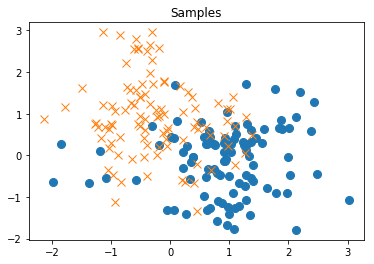

In [5]:
samples_per_class = 100

# Sample actual data sampling from Normal distributions positioned around the centroids
class0_labels = np.random.randint(10, size = samples_per_class)
class1_labels = np.random.randint(10, size = samples_per_class)

class0_samples = class0_centroids[class0_labels, :] + np.sqrt(1. / 5) * np.random.randn(samples_per_class, 2)
class1_samples = class1_centroids[class1_labels, :] + np.sqrt(1. / 5) * np.random.randn(samples_per_class, 2)

# Plot data
plt.plot(class0_samples[:, 0], class0_samples[:, 1], "o", markersize=8)
plt.plot(class1_samples[:, 0], class1_samples[:, 1], "x", markersize=8)
plt.title("Samples")

C’est le problème que nous voulons résoudre: on nous donne ces points et nous voulons trouver une frontière de décision assurant la généralisation, c’est-à-dire que nous pourrons classer correctement les nouveaux échantillons une fois qu’ils nous auront été fournis.

Groupons les données de manière agréable. Pour les problèmes de classification binaire comme celui-ci, la manière dont les données sont arrangées est généralement toujours la même.
- une matrice des données $ X $ de taille $ N \times P $, où $ N $ est le nombre d'échantillons et $ P $ est le nombre de parametres (ou descripteurs/features) (dans notre cas, $ N = 200 $ et $ P = 2 $) ;
- un vecteur de label $ y \in \{0, 1 \} ^ N $ indiquant à quelle classe appartient chaque échantillon

In [6]:
X = np.vstack((class0_samples, class1_samples))
y = np.hstack((np.zeros(samples_per_class), np.ones(samples_per_class)))

print(X)
print(y)

n_samples, n_features = np.shape(X)

[[-1.83993054  0.26291117]
 [ 1.77386445  1.59023315]
 [ 1.29172165  0.74283602]
 [ 0.9099227   0.06832302]
 [ 1.36805748  0.61410042]
 [ 1.2784422   1.70154997]
 [ 0.67266432 -1.25851387]
 [ 1.10417344  0.70138083]
 [ 0.74037497  0.27221135]
 [ 0.9050597  -0.13197968]
 [ 0.93855826 -0.0829923 ]
 [ 0.11596788  0.82816713]
 [ 1.87075347  0.85986017]
 [ 1.45082202  0.40982376]
 [ 0.93421619 -0.13857333]
 [-0.18160778  0.23849717]
 [ 1.28420368  0.11861436]
 [ 1.58346633  0.63014348]
 [ 0.75618498  0.25664195]
 [ 0.06748137 -1.30573929]
 [ 0.52378618  0.8111847 ]
 [ 1.27042146 -0.74001798]
 [ 0.95976188  1.03373503]
 [ 1.07732321  0.40101775]
 [ 0.66790824  0.44884177]
 [-1.08915858 -0.53553715]
 [ 0.62487557 -1.3016676 ]
 [ 1.79281463 -0.91238253]
 [ 0.39090036 -0.03952038]
 [ 2.38419723  0.57235909]
 [ 0.21790757 -0.30167357]
 [ 0.95640237  0.24933959]
 [ 2.43988866  1.29149794]
 [ 1.10237361 -1.27542742]
 [ 1.40041834 -0.60841828]
 [-1.19113697  0.09351802]
 [ 1.06889331 -0.91110399]
 

Ensuite, nous calculons la matrice de distance, une matrice $ N \times N $ contenant la distance entre chaque échantillon et tous les autres (en avons-nous vraiment besoin?)

**Exercice** : calculez la matrice de distance.

In [8]:
def compute_distances(X):
    distances = np.zeros((2*samples_per_class,2*samples_per_class))
    for i in range(2*samples_per_class):
        for j in range(i+1,2*(samples_per_class)):
            distances[i][j] = ((X[i][0] - X[j][0])**2 + (X[i][1] - X[j][1])**2)**(1/2)
            distances[j][i] = distances[i][j] 
    return distances
compute_distances(X)

array([[0.        , 3.84984388, 3.16821295, ..., 1.98688531, 1.84557574,
        1.76881668],
       [3.84984388, 0.        , 0.97495825, ..., 2.25691639, 2.03627276,
        2.20304501],
       [3.16821295, 0.97495825, 0.        , ..., 2.01895578, 1.33191728,
        1.41152745],
       ...,
       [1.98688531, 2.25691639, 2.01895578, ..., 0.        , 1.14026174,
        1.37802546],
       [1.84557574, 2.03627276, 1.33191728, ..., 1.14026174, 0.        ,
        0.26922613],
       [1.76881668, 2.20304501, 1.41152745, ..., 1.37802546, 0.26922613,
        0.        ]])

Nous ne voulons pas vraiment utiliser les boucles en Python, alors re-ecrivez cette routines sans boucles!

In [9]:
distances = compute_distances(X)
%timeit compute_distances(X)
print(distances)

# Try to create a function without any loop

def compute_distances_no_loop(X):
    
    return distances

""""distances = compute_distances_no_loop(X)
%timeit compute_distances_no_loop(X)
print(distances)"""

# Compare your function with one that someone already wrote in C
# Look for such a function in the documentation of scipy and replace the ???
from scipy.spatial import distance_matrix
distances = distance_matrix(X, X)
%timeit distance_matrix(X, X)
print(distances)

62 ms ± 4.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
[[0.         3.84984388 3.16821295 ... 1.98688531 1.84557574 1.76881668]
 [3.84984388 0.         0.97495825 ... 2.25691639 2.03627276 2.20304501]
 [3.16821295 0.97495825 0.         ... 2.01895578 1.33191728 1.41152745]
 ...
 [1.98688531 2.25691639 2.01895578 ... 0.         1.14026174 1.37802546]
 [1.84557574 2.03627276 1.33191728 ... 1.14026174 0.         0.26922613]
 [1.76881668 2.20304501 1.41152745 ... 1.37802546 0.26922613 0.        ]]
1.44 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
[[0.         3.84984388 3.16821295 ... 1.98688531 1.84557574 1.76881668]
 [3.84984388 0.         0.97495825 ... 2.25691639 2.03627276 2.20304501]
 [3.16821295 0.97495825 0.         ... 2.01895578 1.33191728 1.41152745]
 ...
 [1.98688531 2.25691639 2.01895578 ... 0.         1.14026174 1.37802546]
 [1.84557574 2.03627276 1.33191728 ... 1.14026174 0.         0.26922613]
 [1.76881668 2.20304501 1.41152745 ... 1.3780

En utilisant la matrice de distance, nous pouvons maintenant écrire notre algorithme!

**Exercice**: écrivez une fonction qui calcule l'estimation du voisin $ k $ le plus proche pour chaque point de l'ensemble d'apprentissage. Astuce: recherchez la fonction `np.argpartition`. Quelle est l'erreur de formation?

In [10]:
#?np.argpartition
x=[1,5,8,65,3]
x2=np.argpartition(x,3)
print(x2)

[0 4 1 2 3]


In [11]:
def knn(X, y, k):
    distances=distance_matrix(X,X)
    estimate=np.array([])
    for vecteur in distances:
        estimation=0
        vecteurttrie=np.argpartition(vecteur,k) #argpartition retourne un tableau d'indice pour avoir les 
                                                #indices des k premiers voisins dans les k premieres cases
        
        for a in range(1,k): #On s'interesse au k premieres cases du tableau d'indice correspondant au knns
            estimation=estimation+y[vecteurttrie[a]]
        estimation=np.round(estimation/9)    #notre estimation est l'arrondi de la moyenne des valeurs des knns
        estimate=np.append(estimate,estimation)    
    return estimate

est_labels = knn(X, y, 10)
print(est_labels)

# Let us compute the training error
train_error = np.mean(y != est_labels)
print(train_error)

[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 0. 1. 1. 1.]
0.16


La première moitié du vecteur devrait être composée uniquement de 0 et la seconde moitié devrait être composée de 1; nous pouvons voir cependant qu'il y a des erreurs. Laissez-nous les comploter pour essayer de comprendre ce qui se passe.

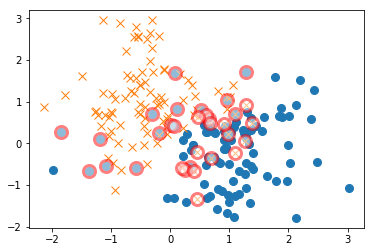

In [12]:
# Plot data
plt.plot(X[y == 0, 0], X[y == 0, 1], "o", markersize=8)
plt.plot(X[y == 1, 0], X[y == 1, 1], "x", markersize=8)

# Draw a red circle around misclassified samples
errors = (y != est_labels)
plt.plot(X[errors, 0], X[errors, 1], "o", color="red", markeredgewidth=3, markerfacecolor="white", markersize=12, alpha=0.5)
#plt.plot(X[errors, 0], X[errors, 1], "o", color="red", mew=3, mfc="white", ms=12, alpha=0.5)

Comme on pouvait s'y attendre, des erreurs se produisent dans des régions où la majorité des points appartiennent à l'autre classe.

Mais que se passe-t-il lorsque nous essayons de classer des points qui ne sont pas dans le set d'entrainement (le training set)? Il y a plusieurs façons d'évaluer cela. Par exemple, nous aurions pu utiliser seulement une partie de nos données dans l'ensemble de formation (environ 80%) et utiliser le reste pour calculer l'erreur dite de test.
Puisque dans notre cas cependant le modèle génératif est connu, nous pourrions aussi bien en extraire davantage d’échantillons.

In [13]:
# Sample test data from the model
import scipy.spatial.distance
testsamples_per_class = 10000

class0_testlabels = np.random.randint(10, size = testsamples_per_class)
class1_testlabels = np.random.randint(10, size = testsamples_per_class)
class0_testsamples = class0_centroids[class0_testlabels, :] + np.sqrt(1. / 5) * np.random.randn(testsamples_per_class, 2)
class1_testsamples = class1_centroids[class1_testlabels, :] + np.sqrt(1. / 5) * np.random.randn(testsamples_per_class, 2)

X_test = np.vstack((class0_testsamples, class1_testsamples))
y_test = np.hstack((np.zeros(testsamples_per_class), np.ones(testsamples_per_class)))

# Compute distance matrix between X and X_test
distances_test = scipy.spatial.distance.cdist(X, X_test)
print(distances_test)
print(np.shape(distances_test))

[[2.00456601 2.42456731 4.53259424 ... 1.82450695 1.28598648 3.24101043]
 [2.19340417 2.09371156 1.90764694 ... 3.13931175 2.67008785 0.66518082]
 [1.29967896 1.12853976 1.61754967 ... 2.92047777 1.90233526 0.88397781]
 ...
 [1.72713664 2.0970249  3.63579172 ... 0.90933461 1.43063637 1.59208929]
 [0.58752313 0.97400744 2.81804387 ... 1.87784036 0.63981739 1.48736509]
 [0.37086098 0.80921863 2.79692109 ... 2.05477034 0.49089138 1.69634752]]
(200, 20000)


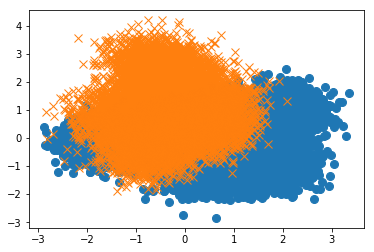

In [14]:
# Plot test data
plt.plot(X_test[y_test == 0, 0], X_test[y_test == 0, 1], "o", ms=8)
plt.plot(X_test[y_test == 1, 0], X_test[y_test == 1, 1], "x", ms=8)

Nous écrivons maintenant une fonction similaire à `knn` qui calcule les estimations non pas pour les points du jeu d’entraînement, mais pour les points d’un nouveau * test *.

In [15]:
def knn_test(X_train, y_train, X_test, y_test, k): #On compare les valeurs de test à leur estimation obetnu par le set de train
    distances_test = distance_matrix(X_test, X_train)
    estimate=np.array([])
    n=0
    for vecteur in distances_test: #On parcours les 20000 vecteur distances de taille 200 associés a chaque points de l'ensemble de test
        estimation=0
        vecteurttrie=np.argpartition(vecteur,k)
        for a in range(k): #Meme fonctionement que pour la fonction knn
            estimation=estimation+y_train[vecteurttrie[a]]
        estimation=np.round(estimation/10)    
        estimate=np.append(estimate,estimation) 
    return estimate

est_testlabels = knn_test(X, y, X_test, y_test, 10)
print(est_testlabels)

# Let us compute the test error, now
print(np.mean(y_test != est_testlabels)) #L'erreur trouvé est sensiblement plus élévé que celle obtenu avec knn
#pour l'ensemble de train, ce qui est logique puisqu'on a ici enlevé le biais lié au fait qu'on testait et entrainais
#avec le meme ensemble de points.

[0. 0. 0. ... 1. 1. 1.]
0.17905


L’un des problèmes que nous rencontrons lorsque nous utilisons les l'algorithme kNN est qu’il faut choisir une valeur pour $ k $ - en principe, on ne sait pas comment le faire!
Pour mieux comprendre cela, voyons comment se comportent les erreurs d’entraînement et de test en fonction de $ k $.

k = 1; train error = 0.5, test error = 0.5
k = 2; train error = 0.5, test error = 0.5
k = 3; train error = 0.5, test error = 0.5
k = 4; train error = 0.5, test error = 0.5
k = 5; train error = 0.5, test error = 0.5
k = 6; train error = 0.275, test error = 0.29345
k = 7; train error = 0.2, test error = 0.20795
k = 8; train error = 0.18, test error = 0.1863
k = 9; train error = 0.165, test error = 0.181
k = 10; train error = 0.16, test error = 0.17905
k = 11; train error = 0.155, test error = 0.19255
k = 12; train error = 0.155, test error = 0.19555
k = 13; train error = 0.17, test error = 0.19975
k = 14; train error = 0.155, test error = 0.2043
k = 15; train error = 0.325, test error = 0.3506
k = 16; train error = 0.43, test error = 0.43615
k = 17; train error = 0.47, test error = 0.49255
k = 18; train error = 0.5, test error = 0.5183
k = 19; train error = 0.535, test error = 0.56085


Text(0, 0.5, 'misclassification error')

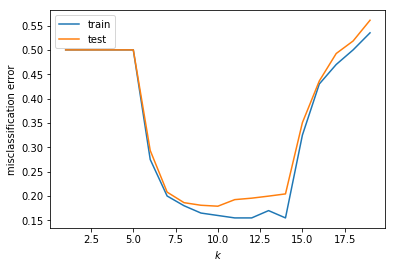

In [16]:
# Convenience functions that compute the training and test errors, given training and test samples
def compute_train_error(X, y, k=1):
    y_hat = knn(X, y, k)
    return np.mean(y != y_hat)
    
def compute_test_error(X_train, y_train, X_test, y_test, k=1):
    y_hat = knn_test(X_train, y_train, X_test, y_test, k)
    return np.mean(y_test != y_hat)

# Run functions for k belonging to a range of values
ks = np.arange(1, 20)
train_error = []
test_error = []
for (i, k) in enumerate(ks):
    train_error.append(compute_train_error(X, y, k))
    test_error.append(compute_test_error(X, y, X_test, y_test, k))
    print("k = %d; train error = %g, test error = %g" % (k, train_error[-1], test_error[-1]))

# Plot results
plt.plot(ks, train_error, label = "train")
plt.plot(ks, test_error, label = "test")
plt.legend()
plt.xlabel(r"$k$")
plt.ylabel("misclassification error")

Il est instructif d’utiliser une autre quantité sur l’axe des x au lieu de $k$: le nombre de degrés de liberté $N / k$. En effet, plus le nombre $k$ est grand,   plus le nombre de paramètres effectifs est petit - pensons par exemple à la limite $k = N$ ,  où tout le monde se voit attribuer le meme label!

k = 1; train error = 0.5, test error = 0.5
k = 2; train error = 0.5, test error = 0.5
k = 3; train error = 0.5, test error = 0.5
k = 4; train error = 0.5, test error = 0.5
k = 5; train error = 0.5, test error = 0.5
k = 6; train error = 0.275, test error = 0.29345
k = 7; train error = 0.2, test error = 0.20795
k = 8; train error = 0.18, test error = 0.1863
k = 9; train error = 0.165, test error = 0.181
k = 10; train error = 0.16, test error = 0.17905
k = 40; train error = 0.865, test error = 0.87125
k = 70; train error = 0.99, test error = 0.9971
k = 100; train error = 1, test error = 1
k = 130; train error = 1, test error = 1


(0.0, 0.5)

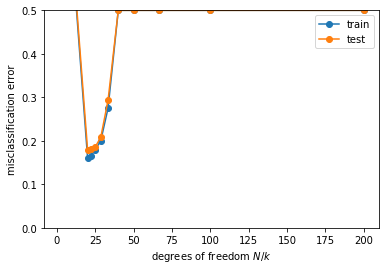

In [17]:
# Re-run the experiment above for a different range of values
ks = np.r_[np.arange(1, 10), np.arange(10, 150, 30)]
train_error = []
test_error = []
for k in ks:
    train_error.append(compute_train_error(X, y, k))
    test_error.append(compute_test_error(X, y, X_test, y_test, k))
    print("k = %d; train error = %g, test error = %g" % (k, train_error[-1], test_error[-1]))

# Plot error as a function of the degrees of freedom
plt.plot(len(y) / np.array(ks), train_error, "-o", label = "train")
plt.plot(len(y) / np.array(ks), test_error, "-o", label = "test")
plt.legend()
plt.xlabel(r"degrees of freedom $N / k$")
plt.ylabel("misclassification error")
plt.ylim((0.0, 0.5))

Ce graphique rend explicite le fameux * compromis biais-variance * qui apparaît dans toutes les études statistiques. Si nous avons plus de paramètres, nous pouvons obtenir une erreur d’entraînement réduite, mais l’erreur de test (par analogie, de généralisation) augmente en fait, ce qui signifie que nous sur-ajustons (over-fitting en anglais)

## A Python library for Machine Learning: scikit-learn

Vous avez peut-être remarqué que l'exécution de notre implémentation $ k $ -NN pour 20000 échantillons commençait déjà à sembler un peu lente… C'est parce qu'elle n'est pas vraiment optimisée. Si nous voulions que les choses soient rapides, nous devrions recourir à du code C, en utilisant des extensions Python telles que Cython ou ctypes (c'est en fait ce que font pour nous des paquets tels que Numpy et Scipy).
De plus, nous avons fait les choses très naïvement - par exemple, il n’est pas nécessaire de calculer la matrice de distance complète si on utilise des structures de données appropriées telles que kd-trees, etc.

Heureusement pour nous, il y a des gens qui ont déjà écrit des versions optimisées de la plupart des algorithmes d'apprentissage automatique standard! L'un des package les. plus populaire est le projet scikit-learn, wui a débuté sous le nom de scikits.learn, un projet Google Summer of Code de David Cournapeau.  Elle est développée par de nombreux contributeurs, et notamment dans le monde académique par des instituts français d'enseignement supérieur et de recherche.

![scikit-learn website](sklearn.png)

Voyons maintenant comment fonctionne l'implémentation k-NN de scikit-learn. Une chose intéressante à propos de scikit-learn est qu’ils ont de nombreux exemples disponibles en ligne. Nous pouvons donc simplement rechercher quelque chose de similaire à ce que nous essayons de faire. Pour la classification k-NN en particulier, il y a cette: http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

In [18]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(10)
clf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

Et fait! Avec seulement trois lignes de code, nous avons pu répéter tout ce que nous avions fait jusqu'à présent. Voyons si nous obtenons la même erreur d’entraînement que précédemment.

In [19]:
train_error = np.mean(y != clf.predict(X))
test_error = np.mean(y_test != clf.predict(X_test))
#train_error = 1. - clf.score(X, y)
#test_error = 1. - clf.score(X_test, y_test)

print("train/test error (for k = 10): %g/%g" % (train_error, test_error))

train/test error (for k = 10): 0.16/0.17905


Puisque les choses sont optimisées ici, nous pouvons même faire des choses plus cool, comme tracer les limites de décision réelles. Pour ce faire, générons une grille et calculons l'estimation pour chaque point de cette grille.

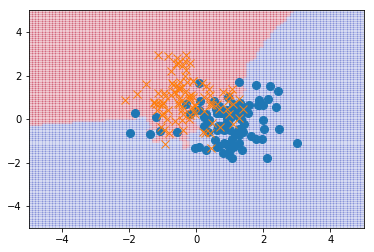

In [20]:
# Create a grid
xx, yy = np.meshgrid(np.linspace(-5, 5, 101), np.linspace(-5, 5, 101))
zz = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Do some plotting
zz = zz.reshape(xx.shape)
plt.pcolormesh(xx, yy, zz, cmap = "coolwarm", alpha = 0.2)
plt.plot(X[y == 0, 0], X[y == 0, 1], "o", markersize=8)
plt.plot(X[y == 1, 0], X[y == 1, 1], "x", markersize=8)

### Determining the best value of $k$ by cross-validation

Une façon de déterminer la "meilleure" valeur de $ k $ consiste à partitionner notre ensemble de données en deux (ensembles de formation et de validation), puis à ajuster sa valeur de manière à minimiser l’erreur de validation (nous avons ensuite besoin d’un troisième ensemble permettant de calculer les valeurs). erreur de test - ne jamais ajuster vos paramètres et calculer l'erreur de test en utilisant le même ensemble!)

Cependant, cela ne nous fournit pas de bonnes statistiques car le partitionnement n’est effectué qu’une seule fois; une meilleure façon de le faire consiste à partitionner le jeu de données à plusieurs reprises et à recalculer le score. C'est l'idée derrière la validation croisée.

scikit-learn a de belles fonctions pratiques pour effectuer une validation croisée (cross-validation) a nous proposer. Nous l'utiliserons souvent par la suite:

In [21]:
from sklearn.model_selection import GridSearchCV

# Set up the grid search
parameters = [{'n_neighbors': np.arange(1, 20)}]
clf = GridSearchCV(neighbors.KNeighborsClassifier(n_neighbors = 1), parameters)
clf.fit(X, y)
# Print results
print(clf.best_params_)
print(clf.cv_results_["mean_test_score"])

{'n_neighbors': 7}
[0.78  0.79  0.815 0.795 0.83  0.835 0.84  0.835 0.84  0.83  0.825 0.83
 0.84  0.825 0.835 0.83  0.84  0.835 0.84 ]


C:\Users\ewenf\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\ewenf\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Voyons comment cela fonctionne sur le test-set:

In [22]:
clf = neighbors.KNeighborsClassifier(18)
clf.fit(X, y)

train_error = np.mean(y != clf.predict(X))
test_error = np.mean(y_test != clf.predict(X_test))
print("train/test error (for optimal k): %g/%g" % (train_error, test_error))

train/test error (for optimal k): 0.17/0.18795


## Classification on real datasets: MNIST

Enfin, laissez-nous travailler avec un vrai jeu de données! Si vous avez déjà étudié un peu de machine learning et de statistiques, vous connaissez probablement le jeu de données MNIST composé de chiffres manuscrits. C'est l'un des ensembles de données les plus célèbres utilisés pour l'analyse comparative des algorithmes de classification et de classification.

Il est également inclus dans scikit-learn:

In [23]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

Jetons un coup d'oeil aux données pour voir à quoi elles ressemblent.

(70000, 784)
(70000,)


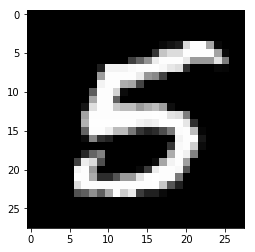

In [24]:
X = mnist.data
y = mnist.target
print(X.shape)
print(y.shape)

n_samples, n_features = np.shape(X)

# Plot a sample
plt.imshow(X[20000, :].reshape((int(np.sqrt(n_features)), -1)), cmap="gray")

# Partition set into train/test
samples = np.random.randint(60000, size = 4000)
X_train, y_train = X[samples, :], y[samples]
X_test, y_test = X[60000:, :], y[60000:]
print(X_train.shape,X_test.shape)


In [25]:
clf = neighbors.KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

train_error = 1. - clf.score(X_train, y_train)
test_error = 1. - clf.score(X_test, y_test)
print("train/test error: %g/%g" % (train_error, test_error))

train/test error: 0.0475/0.0706


Ce n'est pas mauvais...   mais pas tellement bon non plus! Ce n'est pas tres rapide pour commencer... Vous pouvez essayer d'augmenter le nombre d'elements dans le trainign set (ici seulement 1000). Regardons les échantillons mal classés.

(array([   8,   56,  125,  130,  175,  190,  199,  210,  240,  253,  254,
        268,  274,  277,  309,  316,  365,  387,  405,  408,  420,  456,
        483,  491,  500,  514,  547,  556,  558,  561,  568,  569,  572,
        586,  655,  659,  665,  677,  679,  741,  743,  749,  773,  832,
        833,  846,  851,  884,  889,  907,  922,  927,  942,  973,  995,
        999, 1024, 1042, 1044, 1055, 1060, 1120, 1149, 1209, 1246, 1257,
       1277, 1281, 1320, 1483, 1503, 1510, 1516, 1620, 1629, 1641, 1680,
       1681, 1730, 1744, 1772, 1825, 1845, 1890, 1891, 1901, 1920, 1948,
       1966, 1993, 2012, 2032, 2034, 2042, 2046, 2085, 2086, 2102, 2103,
       2108, 2123, 2132, 2144, 2162, 2221, 2229, 2238, 2246, 2249, 2260,
       2266, 2269, 2274, 2320, 2325, 2331, 2342, 2347, 2367, 2378, 2420,
       2442, 2452, 2457, 2460, 2491, 2492, 2502, 2506, 2511, 2513, 2519,
       2533, 2539, 2591, 2618, 2676, 2683, 2747, 2780, 2795, 2798, 2810,
       2817, 2819, 2827, 2841, 2861, 3037, 3050, 3

Text(0.5, 1.0, 'predicted label: 4')

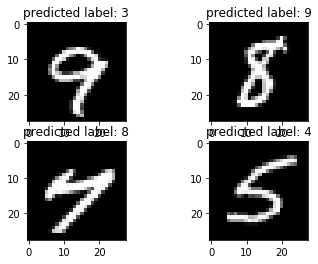

In [26]:
errors = np.where(y_train != clf.predict(X_train))
print(errors)

from random import sample
nums=sample(list(errors[0]),4)

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(X[nums[0], :].reshape((int(np.sqrt(n_features)), -1)), cmap="gray")
axs[0, 0].set_title("predicted label: %d" % (clf.predict(X_train[nums[0], :].reshape(1, -1))))
axs[0, 1].imshow(X[nums[1], :].reshape((int(np.sqrt(n_features)), -1)), cmap="gray")
axs[0, 1].set_title("predicted label: %d" % (clf.predict(X_train[nums[1], :].reshape(1, -1))))
axs[1, 0].imshow(X[nums[2], :].reshape((int(np.sqrt(n_features)), -1)), cmap="gray")
axs[1, 0].set_title("predicted label: %d" % (clf.predict(X_train[nums[2], :].reshape(1, -1))))
axs[1, 1].imshow(X[nums[3], :].reshape((int(np.sqrt(n_features)), -1)), cmap="gray")
axs[1, 1].set_title("predicted label: %d" % (clf.predict(X_train[nums[3], :].reshape(1, -1))))

Auparavant, nous n'exécutions $ k $ -NN que sur deux dimensions; maintenant nos vecteurs sont beaucoup plus gros, ils ont en réalité 768 dimensions. On s'attend à ce que les méthodes locales telles que $ k $ -NN ne fonctionnent pas aussi bien une fois que nous sommes passés à de grandes dimensions. Pourquoi donc?

**exercice** : Nous allons utiliser le dataset "diabete", que vous pouvez telecharger ici: https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv

In [27]:
import pandas as pd
#Load the dataset
df = pd.read_csv('diabetes.csv')
#Print the first 5 rows of the dataframe.
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [28]:
#Let's create numpy arrays for features and target
X = df.drop('Outcome',axis=1).values
y = df['Outcome'].values
print(X.shape,y.shape)

(768, 8) (768,)


Séparons les données au hasard en un ensemble d’entraînement et de test.

Nous allons adapter / former un classifieur sur l'ensemble d'entraînement et faire des prédictions sur l'ensemble d'essai. Ensuite, nous comparerons les prévisions avec les étiquettes connues.

Scikit-learn permet de scinder les données en train et en ensembles de test à l’aide de la méthode train_test_split.

In [29]:
#importing train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=42, stratify=y)

Utilisez maintenant le knn classifier pour prediure le diagnostique d'un diabete a partir des données cliniques.

In [30]:
parameters = [{'n_neighbors': np.arange(1, 20)}] #On cherche le meilleur parametre entre 1 et 20
clf = GridSearchCV(neighbors.KNeighborsClassifier(n_neighbors = 1), parameters)
clf.fit(X_train, y_train)
# Print results
print(clf.best_params_)
print(clf.cv_results_["mean_test_score"])

C:\Users\ewenf\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'n_neighbors': 16}
[0.69782609 0.69565217 0.68913043 0.7173913  0.72391304 0.7326087
 0.72608696 0.7326087  0.74347826 0.74565217 0.73913043 0.73695652
 0.74565217 0.74782609 0.75434783 0.75869565 0.74782609 0.73913043
 0.74782609]


In [32]:
train_error = np.mean(y_train != clf.predict(X_train))
test_error = np.mean(y_test != clf.predict(X_test))
print("train/test error (for optimal k): %g/%g" % (train_error, test_error))

train/test error (for optimal k): 0.23913/0.266234
